In [ ]:
pip install -r requirements.txt

In [15]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from backtesting import Strategy, Backtest
import matplotlib.pyplot as plt
import seaborn as sns

# Download the price data

In [ ]:
def download_data_yfinance(ticker_symbol, timeframe, start_date, end_date):
    ticker = yf.Ticker(ticker_symbol)

    df = ticker.history(start=start_date, end=end_date, interval=timeframe)
    df.drop(columns=["Dividends", "Stock Splits"], inplace=True)
    df.index = df.index.tz_convert('Europe/Paris')
    df.to_csv(f"raw/{ticker_symbol.upper()}_{timeframe.upper()}_{start_date}_{end_date}.csv")

    print("Data downloaded successfully in Data folder.")

download_data_yfinance("META", "5m", "2025-02-01", "2025-03-10")

# Example ticker symbols: AAPL, MSFT, NVDA, TSLA, AMZN, GOOGL, FB ...
# Example timeframes: 1m, 5m, 15m, 30m, 1h, 1d
# Example start_date and end_date: 2025-02-01

In [16]:
df = pd.read_csv("raw/META_5M_2025-02-01_2025-03-10.csv")
pd.set_option('display.max_columns', None)
#print(df.info())
#print(df.head())
#print(len(df))

## Bollinger Scalping Strategy

### How the Strategy Works

- **Indicators Used:**  
  - **EMA:** Two exponential moving averages (30 and 50 periods) to detect trend direction.  
  - **ATR:** Measures candle size to set stop loss and take profit.  
  - **Bollinger Bands:** Based on 15 periods, used for a secondary signal.

- **Signals:**  
  - The DataFrame stores:
    - `0` = No signal  
    - `1` = Sell signal  
    - `2` = Buy signal  
  - Over a 7-candle window:
    - If `EMA_fast < EMA_slow` → Add `1` (bearish)  
    - If `EMA_fast > EMA_slow` → Add `2` (bullish)  
    - Else → Add `0`  
  - A second signal is triggered if the price deviates from the 15-period SMA by more than **1.5σ**.  
  - The final trading signal is the **intersection of both conditions**.

- **Trade Management:**  
  - Only one trade at a time (the previous position must be closed before opening a new one).  
  - Stop loss and take profit are set at entry, based on:
    - `TPSL` (Take Profit / Stop Loss ratio)  
    - `SL_coef` (Stop Loss coefficient derived from ATR)


# Indicators

In [17]:
df = pd.read_csv("raw/META_5M_2025-02-01_2025-03-10.csv")

df=df[df['Volume']!=0] 
df.reset_index(drop=True,inplace=True)
df["EMA_slow"]=ta.ema(df.Close, length=50) 
df["EMA_fast"]=ta.ema(df.Close, length=30) 
df['RSI']=ta.rsi(df.Close, length=10) 
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7) 
df = df.join(my_bbands, how='left')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.head())


                    Datetime        Open        High         Low       Close  \
0  2025-02-03 19:35:00+01:00  701.780029  702.820007  701.320007  702.020020   
1  2025-02-03 19:40:00+01:00  702.114990  702.799988  700.549988  701.744995   
2  2025-02-03 19:45:00+01:00  701.744995  703.750000  701.700073  703.132385   
3  2025-02-03 19:50:00+01:00  703.215027  703.880005  702.640015  703.333191   
4  2025-02-03 19:55:00+01:00  703.039978  704.000000  703.020020  703.405823   

   Volume    EMA_slow    EMA_fast        RSI       ATR  BBL_15_1.5  \
0  154300  696.672314  698.696401  63.006976  1.921094  697.452014   
1  142640  696.871243  698.893084  60.892677  1.968102  697.655768   
2  163199  697.116778  699.166587  67.083836  1.979796  697.848252   
3  150358  697.360559  699.435401  67.901056  1.874074  698.130038   
4  115607  697.597628  699.691557  68.218172  1.746310  698.669322   

   BBM_15_1.5  BBU_15_1.5  BBB_15_1.5  BBP_15_1.5  
0  699.867981  702.283948    0.690407    0.945

# Entry/Exit signals

In [18]:
### EMA Signal (Exponential Moving Average) ###

def ema_signal(df, current_candle, backcandles):
    start = max(0, current_candle - backcandles)
    end = current_candle
    relevant_rows = df.iloc[start:end]
    if all(relevant_rows["EMA_fast"] < relevant_rows["EMA_slow"]):
        return 1 
    elif all(relevant_rows["EMA_fast"] > relevant_rows["EMA_slow"]):
        return 2
    else:
        return 0

def total_signal(df, current_candle, backcandles):
    if (ema_signal(df, current_candle, backcandles)==2
        and df.Close[current_candle]<=df['BBL_15_1.5'][current_candle]):
            return 2
    if (ema_signal(df, current_candle, backcandles)==1
        and df.Close[current_candle]>=df['BBU_15_1.5'][current_candle]):
            return 1
    return 0

def pointpos(x):
    if x['TotalSignal']==1:
        return x['High']*1.01
    elif x['TotalSignal']==2:
        return x['Low']*0.99
    else:
        return 0

def SIGNAL():
    return df['TotalSignal']


df['EMASignal'] = df.apply(lambda row: ema_signal(df, row.name, 7) , axis=1)
df['TotalSignal'] = df.apply(lambda row: total_signal(df, row.name, 7), axis=1)
df['pointpos'] = df.apply(pointpos, axis=1)

print(df.head())

                    Datetime        Open        High         Low       Close  \
0  2025-02-03 19:35:00+01:00  701.780029  702.820007  701.320007  702.020020   
1  2025-02-03 19:40:00+01:00  702.114990  702.799988  700.549988  701.744995   
2  2025-02-03 19:45:00+01:00  701.744995  703.750000  701.700073  703.132385   
3  2025-02-03 19:50:00+01:00  703.215027  703.880005  702.640015  703.333191   
4  2025-02-03 19:55:00+01:00  703.039978  704.000000  703.020020  703.405823   

   Volume    EMA_slow    EMA_fast        RSI       ATR  BBL_15_1.5  \
0  154300  696.672314  698.696401  63.006976  1.921094  697.452014   
1  142640  696.871243  698.893084  60.892677  1.968102  697.655768   
2  163199  697.116778  699.166587  67.083836  1.979796  697.848252   
3  150358  697.360559  699.435401  67.901056  1.874074  698.130038   
4  115607  697.597628  699.691557  68.218172  1.746310  698.669322   

   BBM_15_1.5  BBU_15_1.5  BBB_15_1.5  BBP_15_1.5  EMASignal  TotalSignal  \
0  699.867981  702.28

# Strategy definition

In [19]:
class ScalpingBollinger_5min(Strategy):
    initsize = 1
    mysize = initsize
    slcoef = 2.1
    TPSLRatio = 2.5
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

# Backtesting

In [20]:
def plot_signals(df):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close']),

                go.Scatter(x=df.index, y=df['BBL_15_1.5'],
                           line=dict(color='green', width=1),
                           name="BBL"),
                go.Scatter(x=df.index, y=df['BBU_15_1.5'],
                           line=dict(color='green', width=1),
                           name="BBU"),
                go.Scatter(x=df.index, y=df['EMA_fast'],
                           line=dict(color='black', width=1),
                           name="EMA_fast"),
                go.Scatter(x=df.index, y=df['EMA_slow'],
                           line=dict(color='blue', width=1),
                           name="EMA_slow")])
    df_filtered = df[df["pointpos"]!=0]
    fig.add_scatter(x=df_filtered.index, y=df_filtered["pointpos"], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")
    fig.show()

def SIGNAL():
    return df['TotalSignal']

def run_strategy(df,strategy,cash=100,margin=1/50,commission=.00):
    bt = Backtest(df, strategy, cash=cash, margin=margin, commission=commission)
    stat = bt.run()
    print(stat)
    fig = bt.plot()


In [21]:
plot_signals(df)

In [22]:
run_strategy(df,ScalpingBollinger_5min, cash=100, margin=1/10, commission=.00)

/tmp/ipykernel_4952/2230561001.py:30: UserWarning:

Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).

/tmp/ipykernel_4952/2230561001.py:30: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                     0.0
End                                    1822.0
Duration                               1822.0
Exposure Time [%]                   68.074602
Equity Final [$]                    83.393361
Equity Peak [$]                    133.501707
Return [%]                         -16.606639
Buy & Hold Return [%]              -10.921347
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -43.755952
Avg. Drawdown [%]                   -7.232274
Max. Drawdown Duration                  907.0
Avg. Drawdown Duration             102.176471
# Trades                                 37.0
Win Rate [%]                         29.72973
Best Trade [%]                       2.842587
Worst Trade [%]                     -1.562822
Avg. Trade [%]                    

/home/joseph/new_venv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

/home/joseph/new_venv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



# Parameter Optimization

/tmp/ipykernel_4952/3971259824.py:2: UserWarning:

Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).

/tmp/ipykernel_4952/3971259824.py:2: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/home/joseph/new_venv/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning:

Searching for best of 441 configurations.



Start                                     0.0
End                                    1822.0
Duration                               1822.0
Exposure Time [%]                   54.580362
Equity Final [$]                   147.349416
Equity Peak [$]                    165.746485
Return [%]                          47.349416
Buy & Hold Return [%]              -10.921347
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -19.72108
Avg. Drawdown [%]                   -2.604223
Max. Drawdown Duration                 1086.0
Avg. Drawdown Duration              38.658537
# Trades                                 65.0
Win Rate [%]                        38.461538
Best Trade [%]                       2.146558
Worst Trade [%]                     -1.191616
Avg. Trade [%]                    

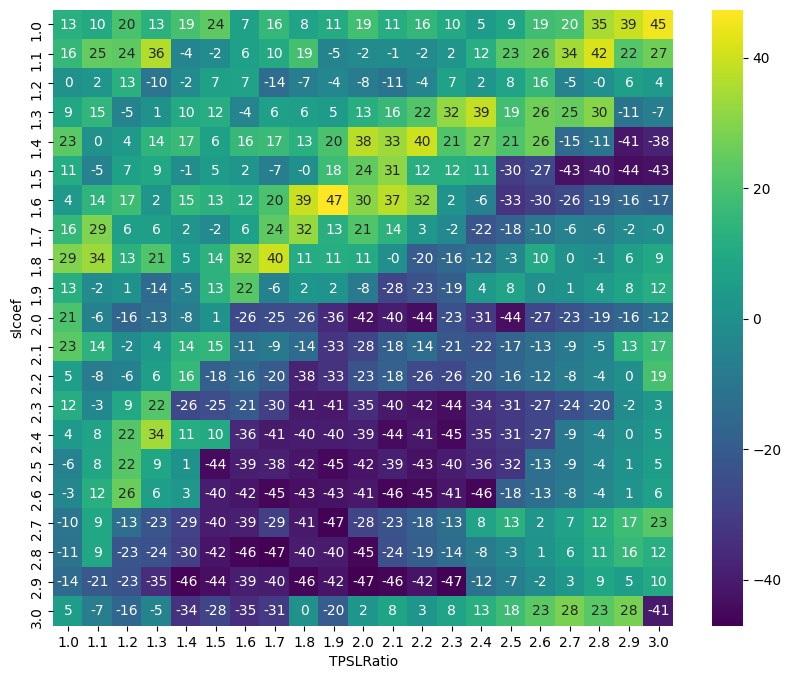

In [25]:
def optimize_strategy(df,strategy, cash=100, margin=1/10, commission=.00):
    bt = Backtest(df, strategy, cash=cash, margin=margin, commission=commission)
    stats,heatmap = bt.optimize(slcoef = [i/10 for i in range(10, 31)], TPSLRatio = [i/10 for i in range(10, 31)],
    maximize = 'Return [%]', max_tries = 500,random_state = 0, return_heatmap=True)
    print(stats)
    print(stats["_strategy"])
    heatmap_df = heatmap.unstack()
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".0f")
    plt.savefig("optimization.png")
    plt.show()

optimize_strategy(df,ScalpingBollinger_5min, cash=100, margin=1/10, commission=.00)



In [28]:
class ScalpingBollinger_5min(Strategy):
    initsize = 1
    mysize = initsize
    slcoef = 1.6
    TPSLRatio = 1.9
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

In [29]:
run_strategy(df,ScalpingBollinger_5min, cash=100, margin=1/10, commission=.00)

/tmp/ipykernel_4952/2230561001.py:30: UserWarning:

Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).

/tmp/ipykernel_4952/2230561001.py:30: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/home/joseph/new_venv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

/home/joseph/new_venv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



Start                                     0.0
End                                    1822.0
Duration                               1822.0
Exposure Time [%]                   54.580362
Equity Final [$]                   147.349416
Equity Peak [$]                    165.746485
Return [%]                          47.349416
Buy & Hold Return [%]              -10.921347
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -19.72108
Avg. Drawdown [%]                   -2.604223
Max. Drawdown Duration                 1086.0
Avg. Drawdown Duration              38.658537
# Trades                                 65.0
Win Rate [%]                        38.461538
Best Trade [%]                       2.146558
Worst Trade [%]                     -1.191616
Avg. Trade [%]                    